# CUSTOMER CHURN PREDICTION FOR SyriaTel TELECOM

## 1.0 Business Understanding

### 1.1 Business Context
SyriaTel is a major tel-com company that just like its competitiors, it experiences customer churn which significantly impact profitability hindering growth and reducing market share. Its also noted that acquairing new customers is more expensive than retaining existing ones.


### 1.2 Problem Statement
The company want to understand patterns leading to churn as well as be able to identify customers likely to leave in the near future for proper actions of retention stategies 

### 1.3 Project Objectives
To address the problem statement, this project aims to 
1. Predict customer Churn -  (churn = True) or not (churn = False)
2. Get factors influencing churn
3. Advise on key retention strategies.

#### 1.3.1 Success Metrics:
From a business perspective, we care most about:

- *Recall*: We want to catch as many churners as possible (even if we sometimes flag non-churners)
- *Precision*: We want to avoid too many false positives (wasting retention offers)
- *F1 Score*: A balance between precision and recall
- *ROC-AUC*: To understand how well our model separates churn vs non-churn




## 2.0 Data Understanding
The dataset was obtained from Kaggle, with 3,333 customer records , each with 21 feautures describing customer demographics, usage patterns, service plans, and support interactions. The target variable is churn (True/False).


In [130]:
# Import essential libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# For modeling and preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

#set plot style
sns.set(style="whitegrid")

In [131]:
#Load Dataset
df= pd.read_csv("SyriaTel Customer Churn.csv", index_col=False)
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [132]:
#Overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

#### Observations
- No missing values accross the columns, all have 3,333 non-null values hence no imputation required
- 4 Columns are of Object (categorical) type(state,phone number,international plan and voice mail plan )
- 8 Columns are float type
- 8 Columns are int type
- 1 column is a bool- churn (target variable)
- The data has 3,333 rows and 21 columns.

## 3.0 DATA Preparation

### 3.1 Data Cleaning

In [133]:
# Check for duplicates

df.duplicated().sum()

# No duplicates

0

##### 3.1.1 Drop irrelevant columns

In [134]:
#Drop irrelevant columns
#phone number is an identifier and not a predictor
#Area code is just a tag of location and state is there

irrelevant_cols =['area code', 'phone number', 'state','account length']
df.drop(columns=irrelevant_cols, inplace=True)


In [135]:
# Convert 'churn' from Boolean to binary numeric (0 = No churn, 1 = Churn)
df['churn'] = df['churn'].astype(int)
df['churn'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3333 entries, 0 to 3332
Series name: churn
Non-Null Count  Dtype
--------------  -----
3333 non-null   int32
dtypes: int32(1)
memory usage: 13.1 KB


### 3.1.2 Target distribution to check imbalance

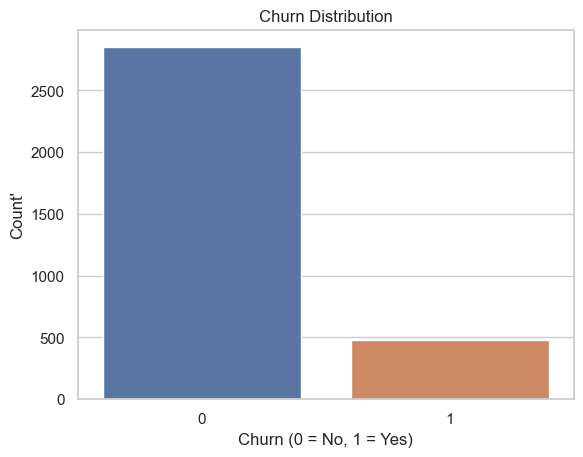

In [136]:
#Visualize target distribution to check imbalance

sns.countplot(x='churn', data=df)
plt.title("Churn Distribution")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count'")
plt.show()

In [137]:
#in percentages
df['churn'].value_counts(normalize=True)

0    0.855086
1    0.144914
Name: churn, dtype: float64

#### Observation

- The Target is inbalanced with only 14% churners. this will be handled by balancing the weight on the regression model to avoid it learning only to predict "NO CHURN"

### 3.1.3 Correlation matrix for Numeric Variables 
- we check for highly correlated features and drop some to avoid redundancy , multicolianility and simplicity.


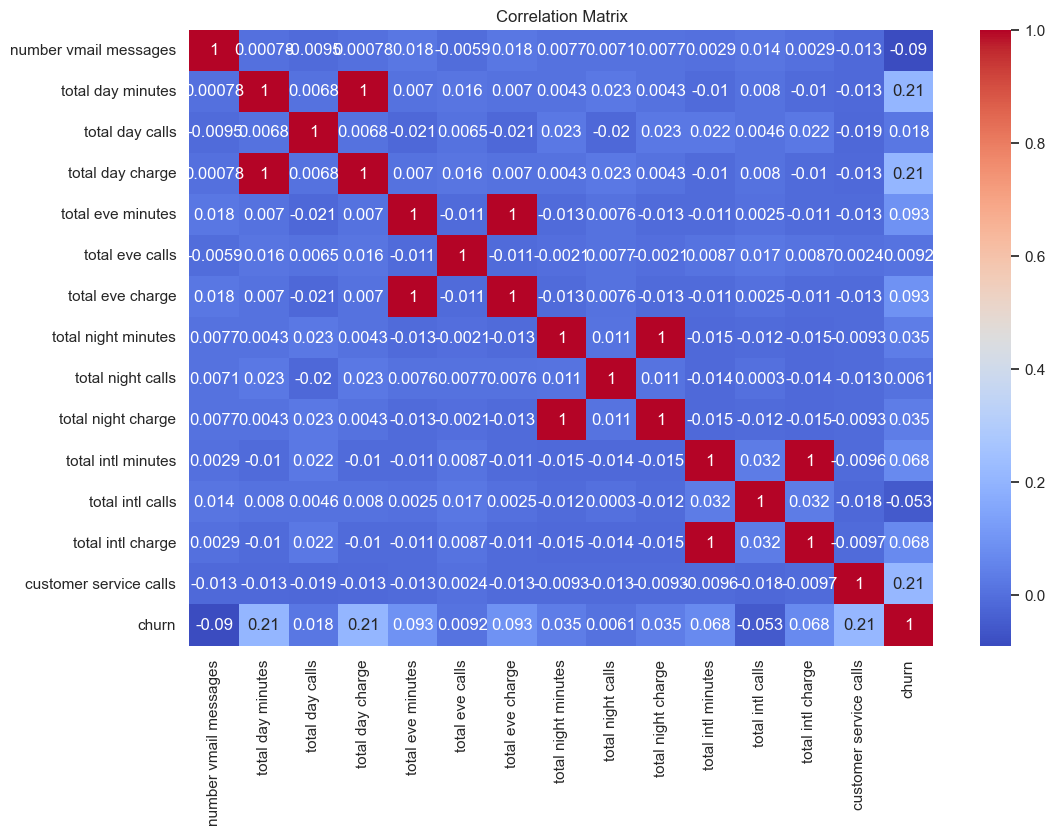

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [139]:

# Get numeric columns
num_df = df.select_dtypes(include='number')
corr = num_df.corr()

# Drop highly correlated features (|corr| > 0.9)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
drop_high = [col for col in upper.columns if (upper[col].abs() > 0.9).any()]

# drop
to_drop = list(set(drop_high))
df_reduced = df.drop(columns=to_drop,inplace=True)

print(f"Dropped columns: {to_drop}")



Dropped columns: ['total night charge', 'total intl charge', 'total day charge', 'total eve charge']


#### Observations

These features were dropped because they are **highly correlated** with other numeric features. Including both in the model can introduce **multicollinearity**, which may distort the model's ability to estimate the true effect of each variable.

| Dropped Feature         | Highly Correlated With       |
|-------------------------|------------------------------|
| `total day charge`      | `total day minutes`          |
| `total eve charge`      | `total eve minutes`          |
| `total night charge`    | `total night minutes`        |
| `total intl charge`     | `total intl minutes`         |

**Justification**:  
To reduce redundancy and simplify the model:
- Only one from each pair is retained, typically the one **more strongly correlated with the target (`churn`)** or **easier to interpret**.
- Dropping the redundant one helps prevent overfitting and improves interpretability.


In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   international plan      3333 non-null   object 
 1   voice mail plan         3333 non-null   object 
 2   number vmail messages   3333 non-null   int64  
 3   total day minutes       3333 non-null   float64
 4   total day calls         3333 non-null   int64  
 5   total eve minutes       3333 non-null   float64
 6   total eve calls         3333 non-null   int64  
 7   total night minutes     3333 non-null   float64
 8   total night calls       3333 non-null   int64  
 9   total intl minutes      3333 non-null   float64
 10  total intl calls        3333 non-null   int64  
 11  customer service calls  3333 non-null   int64  
 12  churn                   3333 non-null   int32  
dtypes: float64(4), int32(1), int64(6), object(2)
memory usage: 325.6+ KB


### 3.1.4 Statistical Feature selection (SelectKBest)
- We apply Chi-square and ANOVA F-test to identify the most relevant features for churn prediction by evaluatin association with out target. 
- Chi-square was used for categorical variables to test the independence between features and the target.
- ANOVA F-test was used for numeric variables to check whether feature means differ significantly across churn categories.

In [141]:


# Encode categorical temporarily
df_encoded = df.copy()
df_encoded['international plan'] = LabelEncoder().fit_transform(df_encoded['international plan'])
df_encoded['voice mail plan'] = LabelEncoder().fit_transform(df_encoded['voice mail plan'])

X = df_encoded.drop(columns='churn')
y = df_encoded['churn']

# Separate numeric & categorical features
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = ['international plan', 'voice mail plan']

# ANOVA for numeric
selector_num = SelectKBest(score_func=f_classif, k='all')
selector_num.fit(X[num_cols], y)
f_scores = selector_num.scores_

print("--"*40)
print("ANOVA for numeric")
print("--"*40)
numeric_scores = pd.Series(f_scores,index=num_cols).sort_values(ascending=False)
print(numeric_scores)

#Drop numurical features with less f_SCORE <2
selected_num_cols = numeric_scores[numeric_scores>=2].index.to_list()

print("--"*40)
print("Chi2 for categoricals")
print("--"*40)

# Chi2 for categoricals
selector_cat= SelectKBest(score_func=chi2,k='all')
selector_cat.fit(X[cat_cols], y)
chi2_scores = selector_cat.scores_

categorical_scores = pd.Series(chi2_scores, index=cat_cols).sort_values(ascending=False)
print(categorical_scores)

#Drop categorical features with chi2 <10
selected_cat_cols = categorical_scores[categorical_scores>=10].index.to_list()

#Final_selected set

Final_selected_cols = selected_cat_cols+selected_num_cols
X_selected = X[Final_selected_cols]


print("--" * 40)
print("Final Selected Columns")
print("--" * 40)
print(Final_selected_cols)




--------------------------------------------------------------------------------
ANOVA for numeric
--------------------------------------------------------------------------------
customer service calls    151.767013
total day minutes         146.350785
total eve minutes          28.932577
number vmail messages      27.035912
total intl minutes         15.583468
total intl calls            9.327945
total night minutes         4.201496
total day calls             1.135412
total eve calls             0.283994
total night calls           0.125631
dtype: float64
--------------------------------------------------------------------------------
Chi2 for categoricals
--------------------------------------------------------------------------------
international plan    203.244178
voice mail plan        25.156959
dtype: float64
--------------------------------------------------------------------------------
Final Selected Columns
------------------------------------------------------------------

#### Observation from Feature selection using SelectKBest
- International plan showed the strongest association with churn in categorical features but Voice mail plan was also significant with 25
- customer service calls and total day minutes had the highest F-scores, indicating strong influence on churn.
- the selected columns captures both plan types and usage behavior which is good for modeling. 

### 3.1.5 Final Features

In [142]:
df_selected = X_selected.copy()
df_selected['churn'] =y

df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   international plan      3333 non-null   int32  
 1   voice mail plan         3333 non-null   int32  
 2   customer service calls  3333 non-null   int64  
 3   total day minutes       3333 non-null   float64
 4   total eve minutes       3333 non-null   float64
 5   number vmail messages   3333 non-null   int64  
 6   total intl minutes      3333 non-null   float64
 7   total intl calls        3333 non-null   int64  
 8   total night minutes     3333 non-null   float64
 9   churn                   3333 non-null   int32  
dtypes: float64(4), int32(3), int64(3)
memory usage: 221.5 KB
